In [1]:
using DataFrames, Dates
import PlotlyJS, Random
Random.seed!(1234)

include("../Engine/Engine.jl")
using .Engine;

WebIO._IJuliaInit()

## Load the data and format it

In [2]:
# data = load_dataset(COP26);

# data = load_dataset(COP27);

data = load_dataset(RandomDays);

## Define the partition, actors and actions

In [3]:
# partition_func = cop_26_dates
# action_func = trust_score
# actor_func = all_users(by_partition=true, min_tweets=3)
# actor_func = IP_scores(by_partition=true, actor_number="all")


partition_func = no_partition
action_func = trust_score
actor_func = all_users(by_partition=true, min_tweets=3)
# actor_func = follower_count(min_tweets=3, actor_number=500, aggregate_size=100000)


# partition_func = cop_26_dates
# action_func = trust_score
# actor_func = IP_scores


# partition_func = cop_27_dates
# action_func = trust_score
# actor_func = follower_count


# partition_func = no_partition
# action_func = trust_score
# actor_func = follower_count

(Main.Engine.PreProcessing.var"#15#16"{Int64}(3), "all_users(by_partition=true, min_tweets=3)")

In [4]:
agents = PreProcessingAgents(partition_func, action_func, actor_func)
df = preprocessing(data, agents);

## Statistics on the data

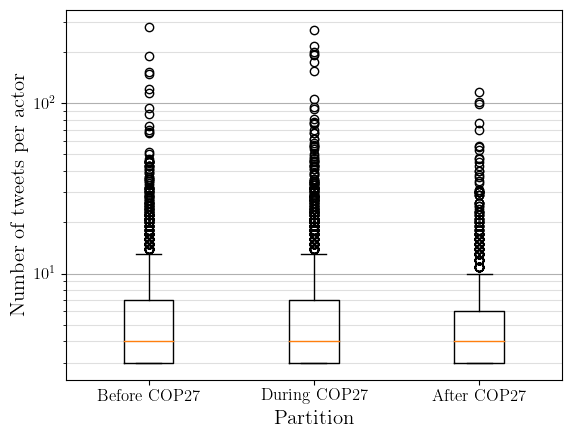

In [5]:
plot_actor_frequency(df, save=false, filename="../../Results/actor_frequency.pdf");

In [6]:
plot_actor_wordcloud(df, Nactor=300, save=false, filename="../../Results/actor_wordcloud.svg")

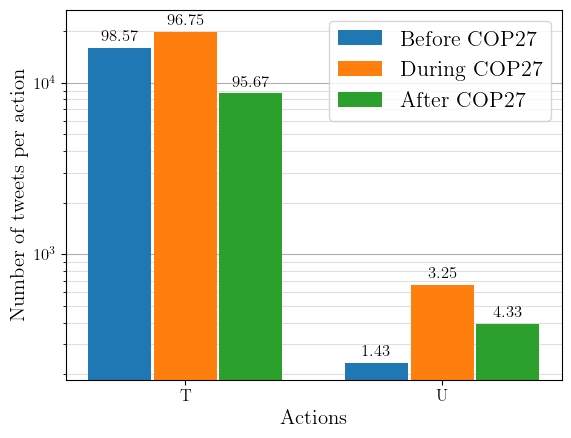

In [7]:
plot_action_frequency(df, save=false, filename="../../Results/action_frequency.pdf");

## Compute influence graph

In [8]:
hours = 2
minutes = 0;

In [9]:
total_min = hours*60 + minutes

# cuttoff = 0.5
# tsg = TimeSeriesGenerator(Minute(total_min), standardize=false)
# ig = InfluenceGraphGenerator(SimpleTE, surrogate=nothing)
# icg = InfluenceCascadeGenerator(cuttoff)


# cuttoff = 0
# tsg = TimeSeriesGenerator(Minute(total_min), standardize=false)
# ig = InfluenceGraphGenerator(SimpleTE)
# icg = InfluenceCascadeGenerator(WithoutCuttoff)


# cuttoff = 0.04
# tsg = TimeSeriesGenerator(Minute(total_min), standardize=false)
# ig = InfluenceGraphGenerator(SimpleTE, surrogate=nothing)
# icg = InfluenceCascadeGenerator(WithoutCuttoff)


# cuttoff = 0
# tsg = TimeSeriesGenerator(Minute(total_min), standardize=true)
# ig = InfluenceGraphGenerator(JointDistanceDistribution, surrogate=nothing, threshold=0.001)
# icg = InfluenceCascadeGenerator(WithoutCuttoff)

using DataStructures
cuttoff = 0
tsg = TimeSeriesGenerator(Minute(total_min), standardize=true)
ig = InfluenceGraphGenerator((x,y) -> 1, OrderedDict())
icg = InfluenceCascadeGenerator(WithoutCuttoff)


# cuttoff = 0
# tsg = TimeSeriesGenerator(Minute(total_min), standardize=true)
# ig = InfluenceGraphGenerator(JointDistanceDistribution, surrogate=nothing, Nsurro=100, threshold=0.001, seed=1234)
# icg = InfluenceCascadeGenerator(WithoutCuttoff)







# ig = InfluenceGraphGenerator(SMeasure)
# ig = InfluenceGraphGenerator(TransferEntropy)

InfluenceCascadeGenerator(0, true)

In [10]:
time_series = observe(df, tsg);

In [11]:
influence_graphs = observe(time_series, ig); 

In [12]:
tot = 0
size = 0
for i in eachindex(influence_graphs)
    for j in eachindex(influence_graphs[i])
        for k in eachindex(influence_graphs[i][j])
            if influence_graphs[i][j][k] == 1
                tot += 1
            end
            size += 1
        end
    end
end

time = size*(0.003194*100 + tot/size)*2.5e-3/3600
print("Estimated time : $time h")

Estimated time : 25.604046727777778 h

## Compute influence cascade

In [13]:
influence_cascades = observe.(influence_graphs, Ref(icg))

edge_types = [string(n1, " to ", n2) for n1 in actions for n2 in actions]
push!(edge_types, "Any Edge");

LoadError: UndefVarError: actions not defined

In [ ]:
foo = plot_betweenness_centrality(influence_graphs, df, cuttoff, width=0.8);

## Plot influence graph

In [ ]:
# partition = "During COP27"
partition = "During COP26"
# partition = "Full dataset"


edge = "T to T";

In [ ]:
partition_index = (1:length(partitions))[findfirst(partition .== partitions)]
	
# In this case we plot the graph on a world map
if actor_func == country
	PlotlyJS.plot(map_plot(df)...)
# In this case we plot a simple graph of the actors
else
	plot_graph(influence_graphs, df, partition_index, cuttoff, edge_type=edge, print_node_names=false)
end

In [ ]:
edge_type = "T to T"
idx = findall(partitions .== "During COP26")[1]
N_biggest = 20

between, between_actors = betweenness_centralities(influence_graphs, df, cuttoff=cuttoff, edge_type=edge_type)
in, in_actors = indegree_centralities(influence_graphs, df, cuttoff=cuttoff, edge_type=edge_type)
out, out_actors = outdegree_centralities(influence_graphs, df, cuttoff=cuttoff, edge_type=edge_type)

between_actors[idx][1:N_biggest]

In [ ]:
plot_edge_types(influence_graphs, df, cuttoff, y="count", log=false, save=false, filename="../../Results/proportion_edges_te.pdf");#, hue_order=["Before COP26", "During COP26", "After COP26"]);

In [ ]:
plot_edge_types(influence_graphs, df, cuttoff, y="count_normalized", log=false, save=false, filename="../../Results/proportion_edges_te.pdf");#, hue_order=["Before COP26", "During COP26", "After COP26"]);

## Plot cascades and statistics

In [ ]:
partition_index = 1
influencer_indices = [ic.root for ic in influence_cascades[partition_index]]
influencers = sort(actors[influencer_indices])

In [ ]:
if length(influencers) > 0
    influencer_node1 = influencers[1]

    PlotlyJS.plot(plot_cascade_sankey(influence_cascades[partition_index][findfirst(influencer_node1 .== influencers)], df)...)
    # PlotlyJS.savefig(PlotlyJS.plot(plot_cascade_sankey(influence_cascades[partition_index][findfirst(influencer_node1 .== influencers)], df)...), "../../Results/cascade.pdf")
end

In [ ]:
plot_actors_per_level(influence_cascades, df, log=false, inner_spacing=0.02, save=false, filename="../../Results/mean_actor_cascade_te.pdf");